## [Practice 7] Building Segmentation
* 0. 실습 환경 설정
* 1. 데이터 준비하기
* 2. 실습에 필요한 클래스 및 함수 정의하기
* 3. Training
* 4. Testing
* 5. Inference

### 0. 실습 환경 설정
* 가상환경명 : deeplabv3p
* Python 버전 : python 3.8
* 설치 목록
    * !pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html
    * opencv-python
    * pandas
    * random2
    * seaborn
    * !pip install numpy>=1.20.3
    * pip install albumentations
        * python3 -m pip install --user albumentations 
        * !pip install -q -U segmentation-models-pytorch albumentations > /dev/null
    * timm==0.9.5
    * pretrainedmodels==0.7.4
* Segmentation_Pytorch Git 주소: https://github.com/qubvel/segmentation_models.pytorch.git

In [8]:
#!git clone https://github.com/qubvel/segmentation_models.pytorch.git

Cloning into 'segmentation_models.pytorch'...


### 1. 데이터 준비하기

In [11]:
import os
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

* TODO : 데이터셋 다운로드 [링크](https://www.kaggle.com/datasets/balraj98/massachusetts-buildings-dataset)
* TODO : `DATA_DIR`에 ${dataset_root}/png 넣어주기

In [23]:
DATA_DIR = 

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_names = ['background', 'building']    # select_classes
class_idx = [0,1]                           # select_class_indices
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

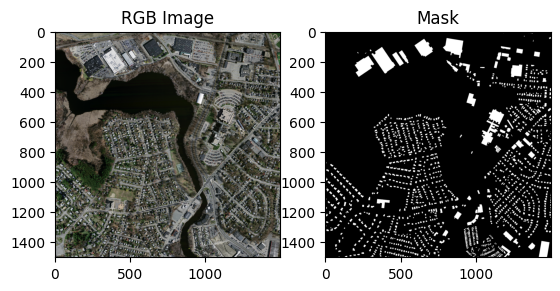

In [15]:
x_sample = cv2.imread(os.path.join(x_train_dir, os.listdir(x_train_dir)[0]))
y_sample = cv2.imread(os.path.join(y_train_dir, os.listdir(y_train_dir)[0]))

plt.figure()
plt.subplot(1,2,1)
plt.title('RGB Image')
plt.imshow(cv2.cvtColor(x_sample, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title('Mask')
plt.imshow(cv2.cvtColor(y_sample, cv2.COLOR_BGR2RGB))

plt.show()

### 2. 실습에 필요한 클래스 및 함수 정의하기

* TODO : 경로이동 (segmentation_models.pytorch root로)

In [ ]:
cd

In [44]:
import os, cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as su

In [58]:
def visualize(**images):
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()


def one_hot_encode(label, label_values):
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

def reverse_one_hot(image):
    x = np.argmax(image, axis = -1)
    return x


def colour_code_segmentation(image, label_values):
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [59]:
class BuildingsDataset(torch.utils.data.Dataset):
    def __init__(
            self,
            images_dir,
            masks_dir,
            class_rgb_values=None,
            augmentation=None,
            preprocessing=None,
    ):

        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing

    def __getitem__(self, i):

        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)

        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')

        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

        return image, mask

    def __len__(self):
        return len(self.image_paths)

In [60]:
def get_training_augmentation():
    train_transform = [
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)

### 3. Training

* TODO : `DATA_DIR`에 ${dataset_root}/png 넣어주기
* TODO : `SAVE_WEIGHT`에 가중치 저장할 폴더경로 넣어주기

In [ ]:
DATA_DIR = 
SAVE_WEIGHT = 

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

TRAINING = True
EPOCHS = 80
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PRETRAING_WEIGHT_PATH = None

In [ ]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_names = ['background', 'building']    # select_classes
class_idx = [0,1]                           # select_class_indices
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

In [61]:
#dataset = BuildingsDataset(x_train_dir, y_train_dir, class_rgb_values=class_rgb_values)
augmented_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    class_rgb_values=class_rgb_values,
)

In [62]:
model = smp.DeepLabV3Plus(encoder_name=ENCODER,encoder_weights=ENCODER_WEIGHTS,classes=len(CLASSES),activation=ACTIVATION)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
if PRETRAING_WEIGHT_PATH is not None and os.path.exists(PRETRAING_WEIGHT_PATH):
    model = torch.load('m_buildings/deeplabv3-efficientnetb4-frontend-using-pytorch/best_model.pth', map_location=DEVICE)

In [68]:
train_dataset = BuildingsDataset(
    x_train_dir, y_train_dir,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)
valid_dataset = BuildingsDataset(
    x_valid_dir, y_valid_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values= class_rgb_values,
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

In [69]:
loss = su.losses.DiceLoss()
metrics = [su.metrics.IoU(threshold=0.5),]
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0001),])
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=1, T_mult=2, eta_min=5e-5,)

In [70]:
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

In [89]:
%%time
if TRAINING:
    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []
    for i in range(0, EPOCHS):
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)
        file_name = f'model_epoch_{i:03d}.pth'
        torch.save(model, os.path.join(SAVE_WEIGHT, file_name))

        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            file_name = f'best_model.pth'
            torch.save(model, os.path.join(SAVE_WEIGHT, file_name))
        print('Best Model Update!')


Epoch: 0
valid: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, dice_loss - 0.2906, iou_score - 0.7465]
Best Model Update!

Epoch: 1
valid: 100%|██████████| 4/4 [00:02<00:00,  1.54it/s, dice_loss - 0.2774, iou_score - 0.7505]
Best Model Update!

Epoch: 2
valid: 100%|██████████| 4/4 [00:02<00:00,  1.50it/s, dice_loss - 0.2497, iou_score - 0.7843]
Best Model Update!

Epoch: 3
valid: 100%|██████████| 4/4 [00:02<00:00,  1.40it/s, dice_loss - 0.2348, iou_score - 0.7848]
Best Model Update!

Epoch: 4
valid: 100%|██████████| 4/4 [00:02<00:00,  1.48it/s, dice_loss - 0.2243, iou_score - 0.7911]
Best Model Update!

Epoch: 5
valid: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s, dice_loss - 0.2302, iou_score - 0.7904]
Best Model Update!

Epoch: 6
valid: 100%|██████████| 4/4 [00:02<00:00,  1.58it/s, dice_loss - 0.2104, iou_score - 0.7945]
Best Model Update!

Epoch: 7
valid: 100%|██████████| 4/4 [00:02<00:00,  1.53it/s, dice_loss - 0.2275, iou_score - 0.765] 
Best Model Update!

Epoch: 8
valid: 100%|██

### 4. Validation

* TODO : 경로이동 (segmentation_models.pytorch root로)

In [ ]:
cd

In [91]:
import os, cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as su

* TODO : `DATA_DIR`에 ${dataset_root}/png 넣어주기
* TODO : `SAVE_WEIGHT`에 가중치 저장한 폴더경로 넣어주기
* TODO : `WEIGHT_FILE_NAME`에 선택한 가중치 파일명 넣어주기

In [92]:
DATA_DIR = 
SAVE_WEIGHT = 
WEIGHT_FILE_NAME = 

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_names = ['background', 'building']    # select_classes
class_idx = [0,1]                           # select_class_indices
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

In [160]:
model = smp.DeepLabV3Plus(encoder_name=ENCODER,encoder_weights=ENCODER_WEIGHTS,classes=len(CLASSES),activation=ACTIVATION)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
if os.path.exists(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME)):
    best_model = torch.load(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME), map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

Loaded DeepLabV3+ model from this run.


In [94]:
test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

In [95]:
test_epoch = su.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid:   0%|          | 0/10 [00:00<?, ?it/s]

valid: 100%|██████████| 10/10 [00:06<00:00,  1.58it/s, dice_loss - 0.1294, iou_score - 0.7939]
Evaluation on Test Data: 
Mean IoU Score: 0.7939
Mean Dice Loss: 0.1294


### 5. Test

* TODO : 경로이동 (segmentation_models.pytorch root로)

In [ ]:
cd

In [97]:
import os, cv2
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import albumentations as album

import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as su

* TODO : `DATA_DIR`에 ${dataset_root}/png 넣어주기
* TODO : `SAVE_WEIGHT`에 가중치 저장한 폴더경로 넣어주기
* TODO : `WEIGHT_FILE_NAME`에 선택한 가중치 파일명 넣어주기

In [98]:
DATA_DIR = 
SAVE_WEIGHT = 
WEIGHT_FILE_NAME = 

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

class_names = ['background', 'building']    # select_classes
class_idx = [0,1]                           # select_class_indices
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

In [117]:
model = smp.DeepLabV3Plus(encoder_name=ENCODER,encoder_weights=ENCODER_WEIGHTS,classes=len(CLASSES),activation=ACTIVATION)
if os.path.exists(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME)):
    model = torch.load(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME), map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

Loaded DeepLabV3+ model from this run.


* TODO : `sample_preds_folder`에 테스트 결과 넣어줄 폴더 경로 넣어주기

In [113]:
sample_preds_folder = 
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)

In [114]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[1500,1500,3]):

    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [115]:
test_dataset_vis = BuildingsDataset(
    x_test_dir, y_test_dir,
    augmentation=get_validation_augmentation(),
    class_rgb_values=class_rgb_values,
)

test_dataset = BuildingsDataset(
    x_test_dir,
    y_test_dir,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=class_rgb_values,
)

(3, 1536, 1536)


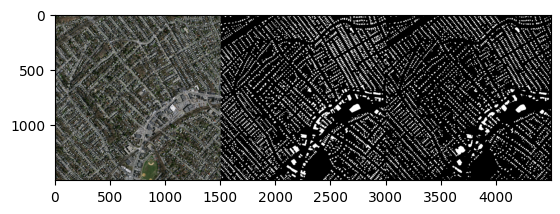

(3, 1536, 1536)


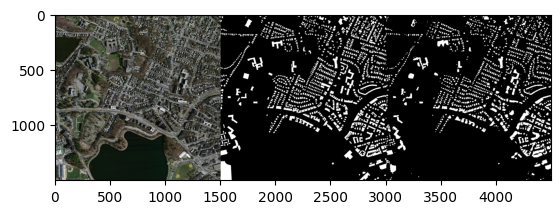

(3, 1536, 1536)


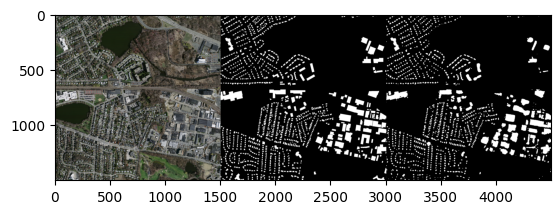

(3, 1536, 1536)


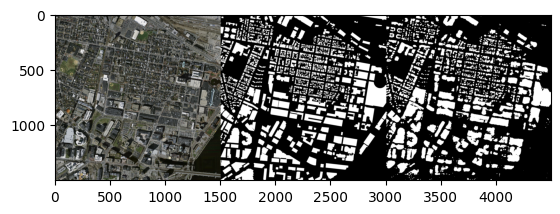

(3, 1536, 1536)


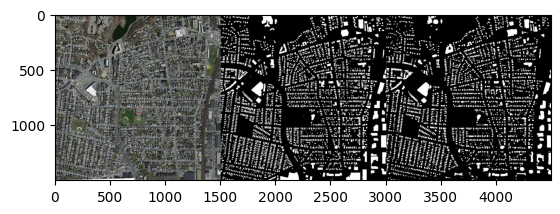

(3, 1536, 1536)


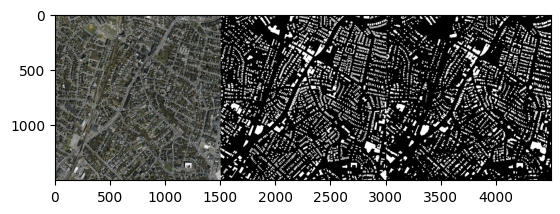

(3, 1536, 1536)


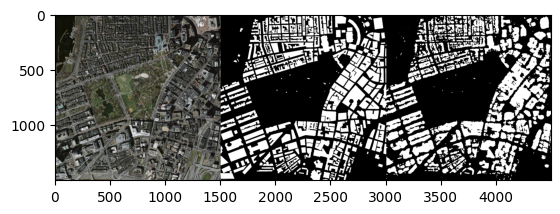

(3, 1536, 1536)


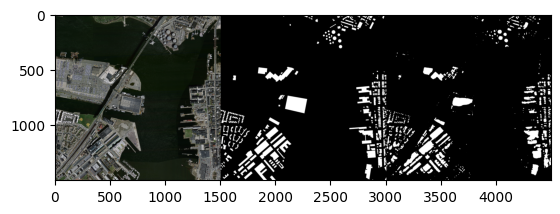

(3, 1536, 1536)


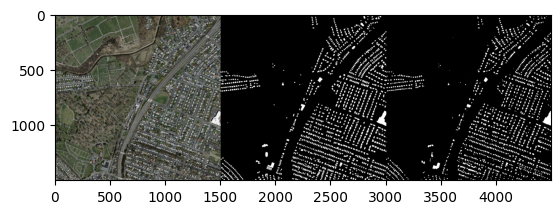

(3, 1536, 1536)


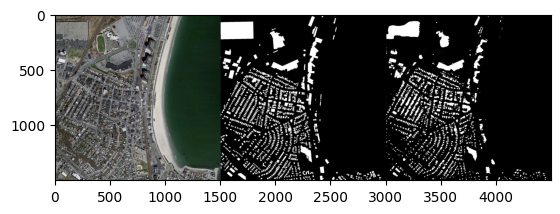

In [143]:
for idx in range(len(test_dataset)):
    image, gt_mask = test_dataset[idx]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pred_mask = model(x_tensor)
    
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    pred_mask = np.transpose(pred_mask,(1,2,0))
    pred_building_heatmap = pred_mask[:,:,class_names.index('building')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), class_rgb_values))
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    
    result = np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1]
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), result)
    
    b,g,r = cv2.split(result)
    result[:,:,0] = r
    result[:,:,2] = b
    plt.imshow(result)
    plt.show()

### 6. Inference

* TODO : 경로이동 (segmentation_models.pytorch root로)

In [ ]:
cd

In [131]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import albumentations as album

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import segmentation_models_pytorch as smp

* TODO : `DATA_DIR`에 ${dataset_root}/png 넣어주기
* TODO : `SAVE_WEIGHT`에 가중치 저장한 폴더경로 넣어주기
* TODO : `WEIGHT_FILE_NAME`에 선택한 가중치 파일명 넣어주기 

In [164]:
DATA_DIR = 
SAVE_WEIGHT = 
WEIGHT_FILE_NAME =

ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class_names = ['background', 'building']    # select_classes
class_idx = [0,1]                           # select_class_indices
class_rgb_values = [[0,0,0], [255,255,255]] # select_class_rgb_values

In [165]:
model = smp.DeepLabV3Plus(encoder_name=ENCODER,encoder_weights=ENCODER_WEIGHTS,classes=len(CLASSES),activation=ACTIVATION)
if os.path.exists(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME)):
    model = torch.load(os.path.join(SAVE_WEIGHT, WEIGHT_FILE_NAME), map_location=DEVICE)
    print('Loaded DeepLabV3+ model from this run.')

print('Model Loaded!')

Loaded DeepLabV3+ model from this run.
Model Loaded!


In [166]:
x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [167]:
def get_validation_augmentation():
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)

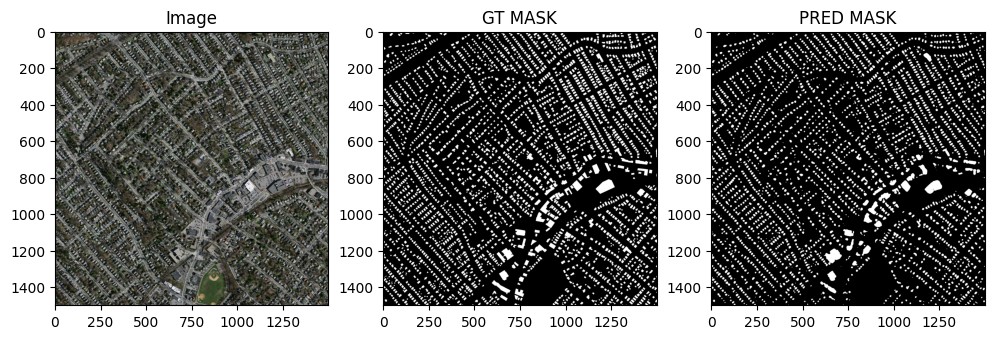

In [170]:
test_img = cv2.imread(os.path.join(x_test_dir, os.listdir(x_test_dir)[0]))
test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
augmentor = album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0)
input_image = augmentor(image=test_img)['image']
input_image = preprocessing_fn(input_image)
input_image = np.transpose(input_image,(2,0,1)).astype('float32')
input_image = torch.from_numpy(input_image).to(DEVICE).unsqueeze(0)

pred_mask = model(input_image)
pred_mask = pred_mask.detach().squeeze().cpu().numpy()

pred_mask = np.transpose(pred_mask,(1,2,0))

pred_building_heatmap = pred_mask[:,:,class_names.index('building')]
pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), class_rgb_values)).astype('uint8')

test_img_label = cv2.imread(os.path.join(y_test_dir, os.listdir(y_test_dir)[0]))
test_img_label = crop_image(cv2.cvtColor(test_img_label, cv2.COLOR_BGR2RGB))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.title("Image")
plt.imshow(test_img)

plt.subplot(1,3,2)
plt.title("GT MASK")
plt.imshow(test_img_label)

plt.subplot(1,3,3)
plt.title("PRED MASK")
plt.imshow(pred_mask)

plt.show()
